# Interactive Chat while tracking Persona Drift

This notebook provides an interactive chat interface that tracks the projection
of model activations onto the assistant axis.

In [7]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn.functional as F
from IPython.display import display, clear_output, HTML
import ipywidgets as widgets
from huggingface_hub import hf_hub_download

from assistant_axis import (
    load_axis,
    get_config,
)

## Load Model and Axis

In [8]:
# Configuration
MODEL_NAME = "meta-llama/Llama-3.3-70B-Instruct"
MODEL_SHORT = "llama-3.3-70b"
REPO_ID = "lu-christina/assistant-axis-vectors"

# Get model config
config = get_config(MODEL_NAME)
TARGET_LAYER = config["target_layer"]
print(f"Model: {MODEL_NAME}")
print(f"Target layer: {TARGET_LAYER}")

Model: meta-llama/Llama-3.3-70B-Instruct
Target layer: 40


In [9]:
# Load model using ProbingModel wrapper
from assistant_axis.internals import ProbingModel

print("Loading model...")
pm = ProbingModel(MODEL_NAME)
model = pm.model
tokenizer = pm.tokenizer
print("Model loaded!")

Loading model...


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Model loaded!


In [15]:
# Load axis from HuggingFace
axis_path = hf_hub_download(repo_id=REPO_ID, filename=f"{MODEL_SHORT}/assistant_axis.pt", repo_type="dataset")
axis = load_axis(axis_path)
print(f"Axis shape: {axis.shape}")

# Normalize
axis_vec = F.normalize(axis[TARGET_LAYER].float(), dim=0)
print(f"Axis vector shape: {axis_vec.shape}")

Axis shape: torch.Size([80, 8192])
Axis vector shape: torch.Size([8192])


## Load and Project Transcript

Load a conversation transcript and compute projections for each assistant turn.

In [ ]:
import json
import matplotlib.pyplot as plt

from assistant_axis.internals import ConversationEncoder, SpanMapper


def load_transcript(filepath):
    """Load a conversation transcript from JSON."""
    with open(filepath) as f:
        data = json.load(f)
    return data['conversation']


def compute_trajectory(pm, conversation, axis_vec, layer):
    """
    Compute projection for each assistant turn in a conversation.
    Uses single forward pass and span mapping (matches fig1_trajectory.ipynb approach).
    """
    encoder = ConversationEncoder(pm.tokenizer)
    span_mapper = SpanMapper(pm.tokenizer)
    
    # Get mean activations for all turns (single forward pass)
    mean_acts = span_mapper.mean_all_turn_activations(pm, encoder, conversation, layer=layer)
    
    # mean_acts shape: (num_turns, hidden_size)
    # Filter to assistant turns only (odd indices: 1, 3, 5, ...)
    assistant_acts = mean_acts[1::2].float()
    
    # Project onto axis (dot product)
    projections = (assistant_acts @ axis_vec).numpy()
    
    return projections


def plot_trajectory(projections, proj_capped=None, title="Projection Trajectory"):
    """Plot projection trajectory, optionally with activation capped line."""
    plt.figure(figsize=(8, 5))
    turns = range(len(projections))
    
    plt.plot(turns, projections, marker='o', label='Unsteered')
    
    if proj_capped is not None:
        plt.plot(range(len(proj_capped)), proj_capped, marker='o', alpha=0.6, label='Activation Capped')
        plt.legend()
    
    plt.xlabel('Conversation Turn (assistant)')
    plt.ylabel('Projection on Assistant Axis')
    plt.title(title)
    plt.tight_layout()
    plt.show()

Loaded 36 turns (18 assistant responses)
Computed 18 projections
Range: [-0.56, 1.69]


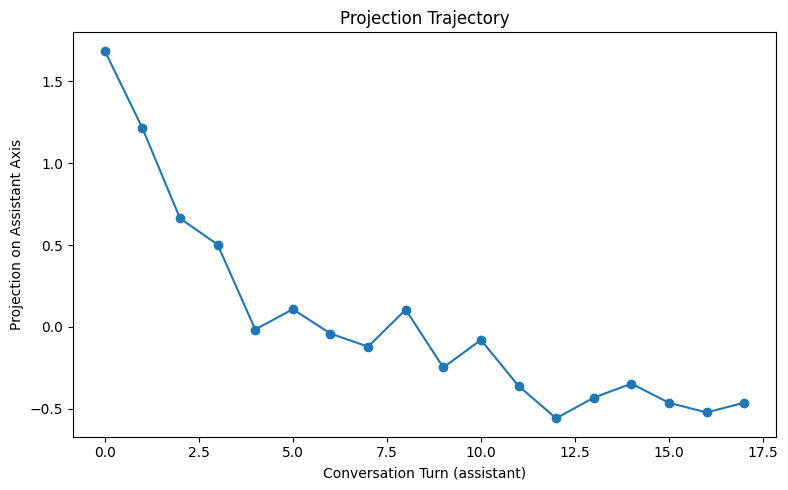

In [18]:
# Load transcript and compute trajectory
transcript_path = "../data/transcripts/llama-3.3-70b/isolation_unsteered.json"

conversation = load_transcript(transcript_path)
print(f"Loaded {len(conversation)} turns ({len(conversation)//2} assistant responses)")

projections = compute_trajectory(pm, conversation, axis_vec, TARGET_LAYER)
print(f"Computed {len(projections)} projections")
print(f"Range: [{projections.min():.2f}, {projections.max():.2f}]")

# Plot trajectory
plot_trajectory(projections, title="Projection Trajectory")